# This script is an alternative-optimizable RADTRANS twin solved and optimized by PyTorch and https://anaconda.org/conda-forge/torchdiffeq

## First we download needed libraries

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
from pylab import *
from datetime import datetime

## Here we define our functions to be integrated. In this case it's Dutkewicz et al. 2015 three-stream ocean optics model (https://bg.copernicus.org/articles/12/4447/2015/) as implemented in Loïc's Macé version of NEMO+BAMBHI+RT ensemble model. 

## Following parameters are computed/set:
### Ed - direct sun irradiance,
### Es - scattered irradiance,
### Eu - backscattered irradiance.
### v_d, v_s, v_u - mean cosines of (1) sun height, scattering and backscattering angles
### a - absorption coefficient, b - scattering coefficient, b_b - backscattering coefficient
### a = a_w + a_phy + a_det +a_cdom
### b = b_w + b_phy + b_det
### b_b = bb_w + bb_phy + bb_det
### for more information see Dutkewicz et al. 2015

# Read (vertical) grid

In [2]:
gridfile = '../current_day/domain_cfg.nc'
griddat = xr.open_dataset(gridfile)
modlev = griddat.e3t_1d.values[0,:]
zlev = np.zeros_like(modlev)
for i in range(len(zlev)):
    zlev[i] = modlev[i]+zlev[i-1]
z_lev = torch.tensor(zlev, dtype=torch.float32) # z-levels red from domain_cfg.nc file

# Read Spectral Irradiances

In [3]:
radfile = '../state_vars/SW_spectral_12h.g10_y2017m08.nc'
dr = xr.open_dataset(radfile)

In [4]:
direct = dr.PSW_SPECTRAL_DIR.values[2,:,60,45]
direct.shape
net = dr.PSW_SPECTRAL.values[2,:,60,45]
diffuse = net - direct
upb = dr.UP_BOUNDS.values[:]
lob = dr.LOW_BOUNDS.values[:]
bds = (upb + lob)/2

## Get spectral bounds

In [5]:
bounds = []
for ii in range(len(bds)):
    bounds.append(round(bds[ii]*1E9))
print(bounds)

[250, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 731, 775, 850, 950, 1050, 1150, 1250, 1350, 1450, 1550, 1650, 1750, 1900, 2200, 2900, 3700]


In [6]:
init_direct = np.zeros(len(modlev))
init_diffuse = np.zeros(len(modlev))
init_back = np.zeros(len(modlev))
init_direct[0] = direct[8]
init_diffuse[0] = diffuse[8]
initial_values = [init_direct, init_diffuse, init_back]
E_init = torch.tensor(initial_values, dtype=torch.float32)
print(E_init)

/tmp/ipykernel_2621619/2376817562.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403238793/work/torch/csrc/utils/tensor_new.cpp:275.)
  E_init = torch.tensor(initial_values, dtype=torch.float32)


tensor([[24.7850,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 6.7607,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 

# Here comes the sun (c) Beatles

In [7]:
class ODESystem(nn.Module):
    def __init__(self, filename):
        super(ODESystem, self).__init__()
        self.read_spectral_data()
        # Read absorbance coefficients from files: 3 PHY, 1 WATER, 1 DETR, 1 CDOM
        self.water_abs = torch.tensor(self.water_coef['abs'][8])
        self.water_sct = torch.tensor(self.water_coef['scat'][8])
        self.water_bsct = torch.tensor(self.water_coef['bscat'][8])
        # abs phyto - each contains 6 wavelens
        self.dia_abs = torch.tensor(self.diatom_coef['abs'][8])
        self.coc_abs = torch.tensor(self.cocco_coef['abs'][8])
        self.bac_abs = torch.tensor(self.lgeuk_coef['abs'][8])
        # scattering by PHY
        self.dia_sct = torch.tensor(self.diatom_coef['scat'][8])
        self.coc_sct = torch.tensor(self.cocco_coef['scat'][8])
        self.bac_sct = torch.tensor(self.lgeuk_coef['scat'][8])
        # & backscattering by PHY
        self.dia_bsct = torch.tensor(self.diatom_coef['bscat'][8])
        self.coc_bsct = torch.tensor(self.cocco_coef['bscat'][8])
        self.bac_bsct = torch.tensor(self.lgeuk_coef['bscat'][8])
        # detrital all
        self.a_det_part = torch.tensor(self.parts_coef['abs'][8])
        self.b_det_part = torch.tensor(self.parts_coef['scat'][8])
        self.bb_det_part = torch.tensor(self.parts_coef['bscat'][8])
        # Define water refraction coefficient before sun_param invocation
        self.refract_water = 1.341
        self.v_d_max = 1.5
        # Read the data
        self.read_bgc_data(filename)
        # Solar zenith abgle 
        self.v_d = self.sun_param()
        # That parameters which are constants as they are in Dutkewicz and Alvarez
        self.v_s = 0.83
        self.v_u = 0.4
        self.r_d = 1.0
        self.r_s = 1.5
        self.r_u = 3.0
        
    def check_leap(self):    # if year is leap = nlen = 366, if not = 365
        leapness = self.year % 4 == 0 and (self.year % 100 != 0 or self.year % 400 == 0)
        if leapness:
            nyear_len = 366
        else:
            nyear_len = 365
        return nyear_len
    
    def get_nsecyear(self):
        tt = pd.to_datetime(self.BAMtim)
        self.year = tt.year
        tt20170101 = pd.to_datetime('20170101T00:00:00')
        tdelta = tt - tt20170101
        self.nsecyear = tdelta.total_seconds().values
    
    def sun_param(self):
        self.get_nsecyear()
        print(self.nsecyear)
        nyear_len = self.check_leap()
        secondsinyear = nyear_len*86400.0
        # nsecyear - number of second between 00h 1 Jan of this year and half of current timestep
        yearangle = 2.0*np.pi*self.nsecyear/secondsinyear
        # delta - declination for current date using Spencers's Fourrier series
        delta = 0.006918 - 0.399912*np.cos(yearangle) + 0.070257*np.sin(yearangle) - 0.006758*cos(2.0*yearangle) + \
                0.000907*np.sin(2.0*yearangle) - 0.002697*np.cos(3.0*yearangle) + 0.001480*np.sin(3.0*yearangle)
        # compute solar zenith angle from declination - cosine of zenith angle is averaged over day-time period
        # this is done for each grid point
        self.read_grid()
        latrad = np.deg2rad(self.lat)
        sun1 = -np.sin(delta)/np.cos(delta) * np.sin(latrad)/np.cos(latrad)
        if sun1 <= -0.999: # what the fuck is this?
            sun1 = -0.999
        elif sun1 >= 0.999:
            sun1 = 0.999
        dayhrs = np.abs(np.arccos(sun1))
        cosz = np.sin(delta)*np.sin(latrad)+(np.cos(delta)*np.cos(latrad)*np.sin(dayhrs)/dayhrs)
        if cosz <= 0.005: # and this?
            cosz = 0.005
        elif cosz >= 0.999:
            cosz = 0.999
        solz = np.rad2deg(np.arccos(cosz)) # this is solar zenith angle
        # Now we compute that v_d angle finally
        sinebelow = np.sin(np.deg2rad(solz))/self.refract_water # refract comes from namelist
        solzbelow = np.arcsin(sinebelow)
        v_d = v_d = np.maximum(0.0, np.minimum(self.v_d_max, 1./np.cos(solzbelow))) # v_d_max comes from namelist
        return torch.tensor(v_d)
    
    def get_wavelen(var, varwav):
        for ii, wav in enumerate(varwav):
            if wav == 400:
                var412 = var[ii] + ((var[ii+1] - var[ii])/25)*12
            if wav == 425:
                var443 = var[ii] + ((var[ii+1] - var[ii])/25)*18
            if wav == 475:
                var490 = var[ii] + ((var[ii+1] - var[ii])/25)*15
            if wav == 500:
                var510 = var[ii] + ((var[ii+1] - var[ii])/25)*10
            if wav == 550:
                var555 = var[ii] + ((var[ii+1] - var[ii])/25)*5
            if wav == 675:
                var670 = var[ii] - ((var[ii+1] - var[ii])/25)*5
        return var412,var443,var490,var510,var555,var670
    
    def read_spectral_data(self):
        waterAbsorbFile     = './spectra_water.dat'
        bactrAbsorbFile     = './spectra_LgEuk.dat'
        diatmAbsorbFile     = './spectra_diatom.dat'
        coccoAbsorbFile     = './spectra_coccolito.dat'
        particleAbsorbFile  = './spectra_particles.dat'
        # pure water coefficients
        self.water_coef = pd.read_csv(waterAbsorbFile, header=6, sep='\s+', \
                         names=['wavelen','abs','scat'])
        water_bscat = self.water_coef['scat']*0.5
        self.water_coef['bscat'] = water_bscat.tolist()
        # Eukariotes which are in our case small flagellates
        self.lgeuk_coef = pd.read_csv(bactrAbsorbFile, header=7, sep='\s+',\
                         names=['wavelen','abs','abs_photo','scat','bscat_coef'])
        lgeuk_bscat = self.lgeuk_coef['scat'] * self.lgeuk_coef['bscat_coef']
        self.lgeuk_coef['bscat'] = lgeuk_bscat.tolist()
        # diatoms are diatoms
        self.diatom_coef = pd.read_csv(diatmAbsorbFile, header=1, sep='\s+',\
                         names=['wavelen','abs','abs_photo','scat','bscat_coef'])
        diatom_bscat = self.diatom_coef['scat'] * self.diatom_coef['bscat_coef']
        self.diatom_coef['bscat'] = diatom_bscat.tolist()
        # Coccolitofores are CEM - pico and nano-flagellates
        self.cocco_coef = pd.read_csv(coccoAbsorbFile, header=1, sep='\s+',\
                         names=['wavelen','abs','abs_photo','scat','bscat_coef'])
        cocco_bscat = self.cocco_coef['scat'] * self.cocco_coef['bscat_coef']
        self.cocco_coef['bscat'] = cocco_bscat.tolist()
        # Detrital matter
        self.parts_coef = pd.read_csv(particleAbsorbFile, header=5, sep='\s+', \
                         names=['wavelen','abs','scat','bscat'])
        
        
    def read_bgc_data(self, filename):
        ds = xr.open_dataset(filename, engine='netcdf4')
        # Particulate organic carbon
        self.POC = torch.tensor(np.nan_to_num(ds.POC.values[0,:,25,25], nan=0))
        # Carbon in phytoplankton
        self.CEM = torch.tensor(np.nan_to_num(ds.CEM.values[0,:,25,25], nan=0)) # pico and nano flagellates
        self.CFL = torch.tensor(np.nan_to_num(ds.CFL.values[0,:,25,25], nan=0)) # small flagellates
        self.CDI = torch.tensor(np.nan_to_num(ds.CDI.values[0,:,25,25], nan=0)) # diatoms
        # Chl-a in phytoplankton
        self.CHE = torch.tensor(np.nan_to_num(ds.CHE.values[0,:,25,25], nan=0)) # pico and nano flagellates
        self.CHF = torch.tensor(np.nan_to_num(ds.CHF.values[0,:,25,25], nan=0)) # small flagellates
        self.CHD = torch.tensor(np.nan_to_num(ds.CHD.values[0,:,25,25], nan=0)) # diatoms
        print(self.CHD)
        # read date and time of the data
        self.BAMtim = ds.time_counter.values[:]
        
    def read_grid(self):
        gridfile = '../current_day/domain_cfg.nc'
        griddat = xr.open_dataset(gridfile)
        self.lat = griddat.nav_lat.values[25,25]
        self.lon = griddat.nav_lon.values[25,25]
            
    def aphy(self):
        # phyto_abs имеет размерность 6 (по кол-ву длин волн)
        a_phy_dia = self.dia_abs*self.CHD # where Chl is chl-a in each phytopl group тоже 6
        a_phy_coc = self.coc_abs*self.CHE
        a_phy_bac = self.bac_abs*self.CHF
        a_phy = a_phy_dia + a_phy_coc + a_phy_bac
        return a_phy  
    
    def bphy(self):
        b_phy_dia = self.dia_sct*self.CDI # wh
        b_phy_coc = self.coc_sct*self.CEM
        b_phy_bac = self.bac_sct*self.CFL
        b_phy = b_phy_dia + b_phy_coc + b_phy_bac
        return b_phy
    
    def bbphy(self):
        bb_phy_dia = self.dia_bsct*self.CDI # wh
        bb_phy_coc = self.coc_bsct*self.CEM
        bb_phy_bac = self.bac_bsct*self.CFL
        bb_phy = bb_phy_dia + bb_phy_coc + bb_phy_bac
        return bb_phy
    
    def detrital(self, det_coef):
        # is not dependent on which coefficient we compute
        p_part = 10e-15 # mmolC/part from Dutkewicz et al. 2015
        c_det = det_coef*(self.POC/p_part) # where POC is POC concentration 
        return c_det
    
    def forward(self, t, y):
        flux1 = y[0][0]
        flux2 = y[1][0]
        # Compute coefficients from constants and params
        a_phy = self.aphy()  # Shape: (59, other_dimensions)
        b_phy = self.bphy()
        bb_phy = self.bbphy()
        a_det = self.detrital(self.a_det_part)
        b_det = self.detrital(self.b_det_part)
        bb_det = self.detrital(self.bb_det_part)
        
        # Compute coefficients at each level
        a = a_phy + a_det + self.water_abs  # Shape: (59, other_dimensions, 1)
        b = b_phy + b_det + self.water_sct  # Shape: (other_dimensions,)
        bb = bb_phy + bb_det + self.water_bsct  # Shape: (59, other_dimensions, 1)
        
        # Compute flux3 based on flux2 and flux1 using coefficients from the correct level
        flux3 = (a + self.r_u * bb) / self.v_u - (self.r_s * bb) / self.v_s - (flux1 * \
                    (self.r_d * bb) + flux2 * (a + self.r_s * bb)) / (flux1 * self.v_d)
        # Integrate the scheme
        dEd_dz = -flux1 * (a + b) / self.v_d
        dEs_dz = -flux2 * (a + self.r_s * bb) / self.v_s + flux3 * (self.r_u * bb) / self.v_u + flux1 * (b - self.r_d * bb) / self.v_d
        dEu_dz = flux3 * (a + self.r_u * bb) / self.v_u - flux2 * (self.r_s * bb) / self.v_s - flux1 * (self.r_d * bb) / self.v_d
        
        return torch.stack([dEd_dz.squeeze(-1), dEs_dz.squeeze(-1), dEu_dz.squeeze(-1)])

In [8]:
ode_system = ODESystem('/scratch/ulg/mast/pverezem/DA_ENS/state_vars/ENS01_BS_ptrc_C001_y2017m08d01.nc')

tensor([1.0643e-01, 1.0644e-01, 1.0646e-01, 1.0648e-01, 1.0650e-01, 1.0653e-01,
        1.0656e-01, 1.0659e-01, 1.0661e-01, 1.0655e-01, 1.0630e-01, 1.0619e-01,
        1.0721e-01, 1.1036e-01, 1.1107e-01, 1.0482e-01, 9.3985e-02, 8.7539e-02,
        4.8194e-02, 1.6817e-02, 1.1777e-02, 8.5104e-03, 4.2517e-03, 3.1032e-03,
        1.7765e-02, 4.8489e-01, 6.4279e-01, 4.1692e-01, 1.2853e-01, 3.6815e-02,
        9.5407e-03, 9.6251e-04, 4.0000e-13, 4.0000e-13, 4.0000e-13, 4.0000e-13,
        1.1061e-07, 3.2246e-07, 1.4445e-07, 2.9986e-08, 1.2459e-08, 5.2226e-09,
        4.0000e-13, 4.0000e-13, 4.0000e-13, 4.0000e-13, 4.0000e-13, 4.0000e-13,
        4.0000e-13, 4.0000e-13, 4.0000e-13, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])
[18360000.]


In [118]:
# Here I can create optimizer and tell it which params I use to optimize

In [ ]:
print(datetime.now().strftime("%H:%M:%S"))
solution = odeint(ode_system, E_init, z_lev)
print(datetime.now().strftime("%H:%M:%S"))
# RRS_below = 
# RRS_model = 
# Вот тут я могу посчитать RRS

18:54:49


In [3]:
# Compute RRS 
# Compare to RRS' -> MSE
# где- то здесь должен быть написан оптимайзер |
# diff back over new parameters
# Optimize MSE

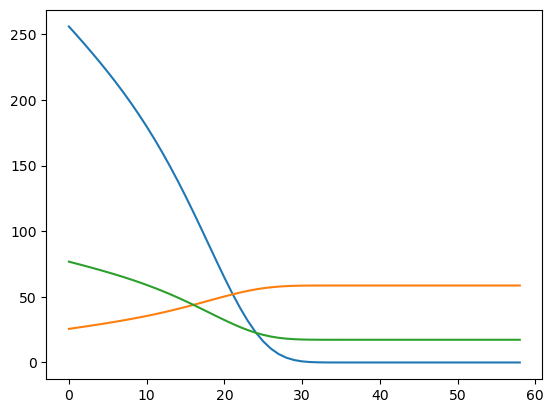

In [15]:
plt.plot(solut)

In [102]:
def check_leap(year):    # if year is leap = nlen = 366, if not = 365
    leapness = year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
    if leapness:
        nyear_len = 366
    else:
        nyear_len = 365
    return nyear_len

In [52]:
def sun_param(lat, lon, time, date):
    ckeck_leap(date)
    secondsinyear = nyear_len*86400.0
    yearangle = 2.0*np.pi()*nsecyear/secondsinyear
    # delta - declination for current date using Spencers's Fourrier series
    delta = 0.006918 - 0.399912*np.cos(yearangle) + 0.070257*np.sin(yearangle) - 0.006758*cos(2.0*yearangle) + \
            0.000907*np.sin(2.0*yearangle) - 0.002697*np.cos(3.0*yearangle) + 0.001480*np.sin(3.0*yearangle)
    # compute solar zenith angle from declination - cosine of zenith angle is averaged over day-time period
    # this is done for each grid point
    latrad = np.deg2rad(self.lat)
    sun1 = -np.sin(delta)/np.cos(delta) * np.sin(latrad)/np.cos(latrad)
    if sun1 <= -0.999: # what the fuck is this?
        sun1 = -0.999
    elif sun1 >= 0.999:
        sun1 = 0.999
    dayhrs = np.abs(np.arccos(sun1))
    cosz = np.sin(delta)*np.sin(latrad)+(np.cos(delta)*np.cos(latrad)*np.sin(dayhrs)/dayhrs)
    if cosz <= 0.005: # and this?
        cosz = 0.005
    elif cosz >= 0.999:
        cosz = 0.999
    solz = np.rad2deg(np.arccos(cosz)) # this is solar zenith angle
    # Now we compute that v_d angle finally
    sinbelow = np.sin(np.deg2rad(solz))/refract_water # refract comes from namelist
    solzbelow = np.arcsin(sinebelow)
    v_d = np.max(0.0, np.min(v_d_max, 1./np.cos(solzbelow))) # v_d_max comes from namelist
    return v_d

## Let's create functions for a and b computation

In [185]:
# Compute the gradients using finite differences
eps = 1e-6
gradients = []
for i in range(len(solution)):
    solution_plus_eps = odeint(model, Ed_sur, z_lev + eps)
    grad = (solution_plus_eps[i] - solution[i]) / eps
    gradients.append(grad)

# Access the gradients
z_lev_grad = torch.cat(gradients, dim=0)

print(z_lev_grad)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -3.8147,  3.8147,
         1.9073,  1.9073,  0.0000,  0.9537,  0.0000,  0.0000,  0.4768,  0.4768,
         0.0000,  0.2384,  0.2384,  0.1192], grad_fn=<CatBackward0>)


## Wavelength bands used in Radtrans:

In [6]:
wavlens = [187.5,312.5,337.5,362.5,387.5,412.5,437.5,462.5,487.5,512.5,537.5,562.5,\
           587.5,612.5,637.5,662.5,687.5,712.5,750,800,900,1000,1100,1200,1300,1400,\
           1500,1600,1700,1800,2000,2400,3400,4000]

In [7]:
wbTotalWidth = 0.0
wbRefWls = []
for i in range(len(wavlens)-1):
    wbWidths = wavlens[i+1] - wavlens[i]
    wbRefWls.append((wavlens[i]+wavlens[i+1])/2)
#     print(wbRefWls)
    wbTotalWidth += wbWidths
    
wbRefWls = np.asarray(wbRefWls)

In [9]:
wbRefWls # just with linear interpolation between wavelens

array([ 250.  ,  325.  ,  350.  ,  375.  ,  400.  ,  425.  ,  450.  ,
        475.  ,  500.  ,  525.  ,  550.  ,  575.  ,  600.  ,  625.  ,
        650.  ,  675.  ,  700.  ,  731.25,  775.  ,  850.  ,  950.  ,
       1050.  , 1150.  , 1250.  , 1350.  , 1450.  , 1550.  , 1650.  ,
       1750.  , 1900.  , 2200.  , 2900.  , 3700.  ])

## Monthly mean water surface albedo 

In [6]:
alpham = [0.095,0.08,0.065,0.065,0.06,0.06,0.06,0.06,0.065,0.075,0.09,0.10]

## Files with absorbances of different matter

In [7]:
waterAbsorbFile     = './spectra_water.dat'
bactrAbsorbFile     = './spectra_LgEuk.dat'
diatmAbsorbFile     = './spectra_diatom.dat'
coccoAbsorbFile     = './spectra_coccolito.dat'
zooplAbsorbFile     = './spectra_zoo.dat'
particleAbsorbFile  = './spectra_particles.dat'
cdomSinusoidal      = './cdom_sinusoidal.dat' # 

### Coefficients for water

In [8]:
water_coef = pd.read_csv(waterAbsorbFile, header=6, sep='\s+', \
                         names=['wavelen','abs','scat'])

In [9]:
water_bscat = water_coef['scat']*0.5
water_coef['bscat'] = water_bscat.tolist()

### Coefficients for phyto and zoo plankton

In [10]:
lgeuk_coef = pd.read_csv(bactrAbsorbFile, header=7, sep='\s+',\
                         names=['wavelen','abs','abs_photo','scat','bscat_coef'])

In [11]:
lgeuk_bscat = lgeuk_coef['scat'] * lgeuk_coef['bscat_coef']
lgeuk_coef['bscat'] = lgeuk_bscat.tolist()

In [29]:
diatom_coef = pd.read_csv(diatmAbsorbFile, header=1, sep='\s+',\
                         names=['wavelen','abs','abs_photo','scat','bscat_coef'])

In [30]:
diatom_bscat = diatom_coef['scat'] * diatom_coef['bscat_coef']
diatom_coef['bscat'] = diatom_bscat.tolist()

In [14]:
cocco_coef = pd.read_csv(coccoAbsorbFile, header=1, sep='\s+',\
                         names=['wavelen','abs','abs_photo','scat','bscat_coef'])

In [15]:
cocco_bscat = cocco_coef['scat'] * cocco_coef['bscat_coef']
cocco_coef['bscat'] = cocco_bscat.tolist()

### Coefficients for detraital matter

In [18]:
parts_coef = pd.read_csv(particleAbsorbFile, header=5, sep='\s+', \
                         names=['wavelen','abs','scat','bscat'])

In [40]:
water_coef['wavelen'] # 400-700 through 25 

0      325
1      350
2      375
3      400
4      425
5      450
6      475
7      500
8      525
9      550
10     575
11     600
12     625
13     650
14     675
15     700
16     725
17     775
18     850
19     950
20    1050
21    1150
22    1250
23    1350
24    1450
25    1550
26    1650
27    1750
28    1900
29    2200
30    2900
31    3700
Name: wavelen, dtype: int64

### Coefficients for CDOM

In [ ]:
# Don't understand yet, so fuck it up 

## Здесь лежит вариант init-a основного кода на тот случай, когда надо будет прочитать все длины волн, а не только те 6, которые требуются для усвоения отраженностей

In [27]:
#         # Read absorbance coefficients from files: 3 PHY, 1 WATER, 1 DETR, 1 CDOM
#         self.water_abs = torch.tensor(water_coef['abs'])
#         self.water_sct = torch.tensor(water_coef['scat'])
#         self.water_bsct = torch.tensor(get_wavelen(water_coef['bscat'], water_coef['wavelen']))
#         # abs phyto - each contains 6 wavelens
#         self.dia_abs = torch.tensor(diatom_coef['abs'])
#         self.coc_abs = torch.tensor(cocco_coef['abs'])
#         self.bac_abs = torch.tensor(lgeuk_coef['abs'])
#         # scattering by PHY
#         self.dia_sct = torch.tensor(diatom_coef['scat']
#         self.coc_sct = torch.tensor(cocco_coef['scat'])
#         self.bac_sct = torch.tensor(lgeuk_coef['scat'])
#         # & backscattering by PHY
#         self.dia_bsct = torch.tensor(diatom_coef['bscat'])
#         self.coc_bsct = torch.tensor(cocco_coef['bscat'])
#         self.bac_bsct = torch.tensor(lgeuk_coef['bscat'])
#         # detrital all
#         self.a_det_part = torch.tensor(parts_coef['abs'])
#         self.b_det_part = torch.tensor(parts_coef['scat'])
#         self.bb_det_part = torch.tensor(parts_coef['bscat'])